In [24]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from itertools import product

In [25]:
rho = 3
h = 0.00000032
m = 48
T = 1
L = 1
sigma = 3.405 #Armstrong
epsilon = 119.8 #K

In [26]:
# Example array
my_array = np.array([3, 0, 1, 4, 2, 0, 5])

# Find the index of the minimum element that is not zero
nonzero_indices = np.nonzero(my_array)  # Get indices where the elements are non-zero
min_nonzero_index = np.argmin(my_array[nonzero_indices])

# Output the result

print("Array:", my_array)
print("Nonzero indices:", nonzero_indices[0])
print("Index of the minimum non-zero element:", nonzero_indices[0][min_nonzero_index])
print("All nonzero elements:", my_array[nonzero_indices[0]])

Array: [3 0 1 4 2 0 5]
Nonzero indices: [0 2 3 4 6]
Index of the minimum non-zero element: 2
All nonzero elements: [3 1 4 2 5]


In [27]:
list_pbc = list(product([0, 1, -1], repeat=3))
list_pbc = L*np.array(list_pbc)

def f(r_i, r_j):
    #Todo: Cut potential for r_ij > sigma
    r_ij_candidates = [np.sum([(r_i[d]-r_j[d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc]
    index_L_min = np.argmin([r_ij_candidates])#list_pbc[index_min]
    vec_L_min = list_pbc[index_L_min]
    r_ij = np.sqrt(r_ij_candidates[index_L_min])
    print(r_ij)
    print(r_ij**(-14))
    f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2]+vec_L_min[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(N_0)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()
    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def build_fcc(rho):
    """
    :param rho: How many points per axis of the L*L cube (minimum 2) 
    :return: fcc grid for the L*L cube (np.array of shape (n_points, 3))
    """
    #Todo: Could cause division by zero because of mirror atoms for the corner points
    range_values_sc = np.linspace(-L/2, L/2, rho)
    length_edge = np.abs(range_values_sc[0]-range_values_sc[1]) #L/(rho-1)
    sc_grid = np.array(list(product(range_values_sc, repeat=3)))
    sc_grid = sc_grid[sc_grid[:, 0] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 1] != -L/2]
    sc_grid = sc_grid[sc_grid[:, 2] != -L/2]
    missing_points = []
    for point in sc_grid:
        p1 = [point[0]+0.5*length_edge, point[1], point[2]+0.5*length_edge]
        p2 = [point[0]+0.5*length_edge, point[1]+0.5*length_edge, point[2]]
        p3 = [point[0], point[1]+0.5*length_edge, point[2]+0.5*length_edge]
        missing_points.append(p1)
        missing_points.append(p2)
        missing_points.append(p3)
    missing_points = np.array(missing_points)
    x = sc_grid[:,0]
    y = sc_grid[:,1]
    z = sc_grid[:,2]
    x_m = missing_points[:,0]
    y_m = missing_points[:,1]
    z_m = missing_points[:,2]
    fcc_grid = np.concatenate([sc_grid, missing_points])

    return fcc_grid

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

In [28]:
r_0 = build_fcc(rho)
N_0 = r_0.shape[0]
#np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,0.000001*np.sqrt(T/48), (N_0, 3))

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

"\nr_0: Initial positions of the system\n    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle\nv_0: Initial velocities of the system particles\n    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle\n"

In [29]:
print(r_0[8])
print(r_0[17])
print([(vec_L, [(r_0[8][d]-r_0[17][d]+vec_L[d])**2 for d in range(3)]) for vec_L in list_pbc])

[0.25 0.   0.25]
[0.25 0.5  0.75]
[(array([0, 0, 0]), [0.0, 0.25, 0.25]), (array([0, 0, 1]), [0.0, 0.25, 0.25]), (array([ 0,  0, -1]), [0.0, 0.25, 2.25]), (array([0, 1, 0]), [0.0, 0.25, 0.25]), (array([0, 1, 1]), [0.0, 0.25, 0.25]), (array([ 0,  1, -1]), [0.0, 0.25, 2.25]), (array([ 0, -1,  0]), [0.0, 2.25, 0.25]), (array([ 0, -1,  1]), [0.0, 2.25, 0.25]), (array([ 0, -1, -1]), [0.0, 2.25, 2.25]), (array([1, 0, 0]), [1.0, 0.25, 0.25]), (array([1, 0, 1]), [1.0, 0.25, 0.25]), (array([ 1,  0, -1]), [1.0, 0.25, 2.25]), (array([1, 1, 0]), [1.0, 0.25, 0.25]), (array([1, 1, 1]), [1.0, 0.25, 0.25]), (array([ 1,  1, -1]), [1.0, 0.25, 2.25]), (array([ 1, -1,  0]), [1.0, 2.25, 0.25]), (array([ 1, -1,  1]), [1.0, 2.25, 0.25]), (array([ 1, -1, -1]), [1.0, 2.25, 2.25]), (array([-1,  0,  0]), [1.0, 0.25, 0.25]), (array([-1,  0,  1]), [1.0, 0.25, 0.25]), (array([-1,  0, -1]), [1.0, 0.25, 2.25]), (array([-1,  1,  0]), [1.0, 0.25, 0.25]), (array([-1,  1,  1]), [1.0, 0.25, 0.25]), (array([-1,  1, -1]), [

In [30]:
for i in range(r_0.shape[0]):
    for j in range(r_0.shape[0]):
        x = f(r_0[i], r_0[j])
        if np.isnan(x[0]):
            print(i,j)

0.0
inf
0 0
0.5
16384.0
0.5
16384.0
0.7071067811865476
127.99999999999987
0.5
16384.0
0.7071067811865476
127.99999999999987
0.7071067811865476
127.99999999999987
0.8660254037844386
7.491540923639695
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9

C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:11: RuntimeWarning: divide by zero encountered in scalar power
  print(r_ij**(-14))
C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:12: RuntimeWarning: divide by zero encountered in scalar power
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  f_x = m*(r_i[0]-r_j[0]+vec_L_min[0])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:13: RuntimeWarning: divide by zero encountered in scalar power
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  f_y = m*(r_i[1]-r_j[1]+vec_L_min[1])*(r_ij**(-14)+0.5*r_ij**(-8))
C:\Users\corin\AppData\Local\Temp\ipykernel_19148\1011440440.py:14: 

In [31]:
f(r_0[8], r_0[17])


0.7071067811865476
127.99999999999987


array([    0., -3264., -3264.])

In [32]:
print(r_0[8],r_0[17])

[0.25 0.   0.25] [0.25 0.5  0.75]


Text(0.5, 0.92, 'Initial state of the Argon ')

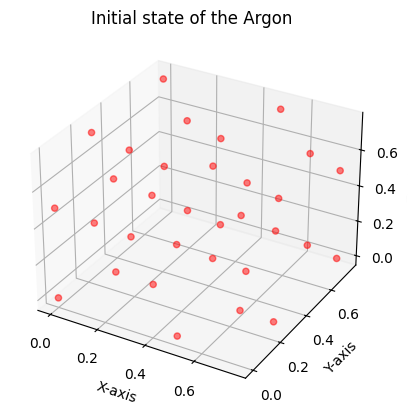

In [33]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='r', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [34]:
t_max = 10
r_total, v_total = verlet_algorithm(r_0, v_0, t_max)

  0%|          | 0/10 [00:00<?, ?it/s]

0.5
16384.0
0.5
16384.0
0.7071067811865476
127.99999999999987
0.5
16384.0
0.7071067811865476
127.99999999999987
0.7071067811865476
127.99999999999987
0.8660254037844386
7.491540923639695
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

0.6123724339625485
958.9172762232691
0.6123724343960183
958.9172667204514
0.3535533890922331
2097152.124650897
0.3535533898427651
2097152.0623244806
0.6123724343958528
958.9172667240803
0.6123724348291751
958.9172572244947
0.3535533898428331
2097152.0623188335
0.35355339059316643
2097152.000008913
0.866025401946101
7.491541146274898
0.6123724348292084
958.9172572237646
0.6123724348291444
958.917257225169
0.7071067796855596
128.00000380390986
0.6123724352624459
958.9172477260411
0.3535533905933129
2097151.999996748
0.7071067796855894
128.00000380383418
0.6123724343959486
958.9172667219798
0.612372434395872
958.9172667236593
0.49999999893871216
16384.000486867924
0.6123724348293256
958.9172572211968
0.3535533898427667
2097152.062324347
0.7071067796855639
128.0000038038989
0.35355339059321844
2097152.0000045937
0.6123724352625386
958.9172477240088
0.49999999893856983
16384.00048693322
0.3535533913437576
2097151.9376775871
0.35355339134367153
2097151.9376847323
0.4999999989386378
16384.000

 20%|██        | 2/10 [00:01<00:06,  1.30it/s]

0.4999999999999388
16384.000000028063
0.49999999999985556
16384.000000066262
0.7071067811864112
128.00000000034538
0.49999999999998757
16384.000000005704
0.707106781186434
128.0000000002877
0.70710678118624
128.00000000077924
0.8660254037841895
7.491540923669867
0.35355339059331
2097151.9999969923
0.35355339059337976
2097151.9999911978
0.35355339059321844
2097152.0000045937
0.35355339059342766
2097151.9999872197
0.6123724356958774
958.9172382240632
0.35355339059329705
2097151.9999980666
0.6123724356958624
958.9172382243919
0.353553390593181
2097152.000007701
0.3535533905932388
2097152.000002902
0.612372435695897
958.9172382236325
0.6123724356957977
958.9172382258108
0.35355339059335555
2097151.9999932076
0.35355339059331564
2097151.9999965222
0.35355339059316104
2097152.0000093607
0.6123724356959016
958.9172382235326
0.35355339059329866
2097151.9999979327
0.6123724356958044
958.9172382256647
0.6123724356955967
958.9172382302162
0.6123724356957061
958.9172382278188
0.35355339059316926
2

 30%|███       | 3/10 [00:02<00:04,  1.47it/s]

0.35355339148679477
2097151.9257993523
0.6123724339230046
958.9172770901778
0.3535533907447617
2097151.9874199883
0.6123724348276947
958.917257256951
0.35355338902206396
2097152.130477953
0.6123724339805441
958.9172758287574
0.35355338826194066
2097152.193600863
0.6123724336585111
958.9172828885812
0.612372434619065
958.9172618306712
0.499999997018721
16384.001367667766
0.3535533927823847
2097151.8182097091
0.6123724350463904
958.9172524625557
0.7071067781142977
128.00000778591306
0.3535533945571679
2097151.6708264374
0.6123724326807369
958.9173043240077
0.7071067783273687
128.0000072459334
0.612372435531913
958.9172418186013
0.6123724347008868
958.9172600369192
0.8660254011776901
7.491541239334692
0.6123724358482031
958.9172348846764
0.3535533879172625
2097152.22222397
0.35355338886916726
2097152.143174951
0.35355339013842263
2097152.037772195
0.4999999972617702
16384.001256168453
0.3535533913548579
2097151.9367557815
0.35355338849356155
2097152.174366372
0.4999999990544888
16384.0004

 40%|████      | 4/10 [00:02<00:03,  1.58it/s]

0.3535533930236603
2097151.7981734648
0.6123724340760578
958.9172737348414
0.35355339145179343
2097151.9287059675
0.612372432008565
958.9173190598161
0.3535533913067759
2097151.9407486573
0.6123724348494548
958.9172567799102
0.3535533897712844
2097152.0682604476
0.6123724301349898
958.917360133599
0.35355339250249584
2097151.8414525106
0.4999999964170145
16384.00164370186
0.6123724323214703
958.9173122000932
0.3535533959257972
2097151.5571713992
0.7071067781834572
128.00000761064396
0.6123724349659875
958.9172542252024
0.3535533877854754
2097152.2331679636
0.3535533895299693
2097152.0882999767
0.35355339161531263
2097151.9151268462
0.4999999962709716
16384.00171069934
0.3535533930563486
2097151.7954589315
0.6123724352348134
958.9172483318183
0.7071067771213952
128.00001030219676
0.6123724317917077
958.9173238139064
0.6123724372740467
958.9172036263735
0.8660253989023934
7.4915415148886355
0.6123724319564114
958.9173202031606
0.6123724320687265
958.9173177409142
0.49999999638726106
1638

 50%|█████     | 5/10 [00:03<00:03,  1.63it/s]

0.35355339086224147
2097151.9776641196
0.3535533887601474
2097152.152228285
0.35355339196391833
2097151.8861775906
0.6123724347139452
958.9172597506432
0.3535533889130687
2097152.1395292445
0.7071067785199152
128.00000675796832
0.3535533883642948
2097152.185101071
0.3535533898627005
2097152.060668982
0.499999997806908
16384.001006085367
0.612372433768939
958.9172804677065
0.6123724330935268
958.9172952745482
0.8660254015163991
7.491541198314731
0.35355338735335934
2097152.269052175
0.6123724348919959
958.9172558472959
0.7071067800525763
128.00000287379004
0.6123724355456306
958.9172415178753
0.3535533911951983
2097151.9500143921
0.4999999989140207
16384.000498195186
0.3535533909613548
2097151.9694334534
0.3535533919695386
2097151.8857108657
0.6123724341284003
958.9172725873545
0.6123724345750688
958.9172627951843
0.7071067800494044
128.0000028818285
0.35355338953293
2097152.0880541126
0.6123724364525764
958.917221635197
0.4999999975075619
16384.001143411002
0.6123724342519761
958.91726

 60%|██████    | 6/10 [00:03<00:02,  1.64it/s]

0.7071067805700306
128.00000156242072
0.35355339166408317
2097151.911076795
0.6123724349509362
958.917254555167
0.49999999913394
16384.00039730676
0.3535533903451135
2097152.020607967
0.35355339005256314
2097152.0449022227
0.6123724336066697
958.9172840250839
0.35355339023011756
2097152.0301575745
0.6123724343460146
958.9172678166655
0.3535533890074304
2097152.131693168
0.6123724348474221
958.9172568244726
0.3535533910112257
2097151.9652920263
0.6123724338567613
958.9172785424066
0.3535533922432375
2097151.8629820945
0.6123724349012247
958.9172556449751
0.7071067791902641
128.0000050591227
0.35355339063520136
2097151.9965182072
0.6123724356989093
958.9172381575958
0.49999999833137865
16384.0007654834
0.35355338871302977
2097152.156141075
0.6123724347299065
958.9172594007279
0.8660254012256741
7.491541233523509
0.612372434013171
958.9172751134885
0.6123724347898637
958.9172580863068
0.7071067796214924
128.00000396627348
0.6123724345063141
958.917264302473
0.3535533922694578
2097151.8608

 70%|███████   | 7/10 [00:04<00:01,  1.63it/s]

0.6123724338033723
958.917279712838
0.6123724364018291
958.9172227477135
0.6123724357421092
958.9172372105387
0.6123724361059097
958.9172292350579
0.35355338814265685
2097152.2035065475
0.3535533916649593
2097151.9110040383
0.35355339175685274
2097151.9033729336
0.35355339219937326
2097151.866624712
0.3535533910265731
2097151.9640175288
0.6123724342545808
958.9172698211403
0.7071067786326969
128.00000647214904
0.612372433179154
958.9172933973715
0.6123724358241306
958.9172354124105
0.8660254003741081
7.491541336653946
0.3535533925588981
2097151.8367686982
0.3535533927383051
2097151.821870208
0.4999999974571592
16384.00116653336
0.6123724350471146
958.9172524466793
0.3535533916893581
2097151.908977888
0.7071067793985136
128.000004531362
0.35355338830293154
2097152.1901968583
0.6123724356567058
958.9172390828085
0.4999999989177587
16384.000496480367
0.6123724341604744
958.9172718842041
0.612372436949821
958.9172107342664
0.7071067794317376
128.00000444716343
0.3535533904911139
2097152.00

 80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

0.49999999708853726
16384.001335639412
0.49999999839835296
16384.0007347588
0.7071067787867521
128.00000608173139
0.49999999726917943
16384.00125276945
0.7071067801151496
128.0000027152124
0.7071067780634585
128.0000079147534
0.8660254011788318
7.491541239196431
0.3535533927502494
2097151.8208783194
0.35355338961364485
2097152.081351308
0.35355339102488953
2097151.9641573397
0.35355338919965834
2097152.1157299844
0.6123724341662314
958.9172717579938
0.35355338950144644
2097152.0906685996
0.6123724356245045
958.9172397887482
0.3535533885941052
2097152.166016929
0.35355338944274106
2097152.095543669
0.6123724322543792
958.9173136709098
0.612372434369066
958.9172673113185
0.35355338870461855
2097152.1568395677
0.35355339208899783
2097151.8757906165
0.35355338995454766
2097152.053041721
0.6123724346089935
958.9172620514655
0.35355338898727895
2097152.1333666034
0.6123724324436942
958.9173095206182
0.612372434658813
958.9172609592891
0.6123724345488643
958.9172633696592
0.35355338740135217


 90%|█████████ | 9/10 [00:05<00:00,  1.57it/s]

0.7071067792413465
128.00000492966618
0.6123724354827098
958.917242897267
0.6123724346794032
958.917260507897
0.8660254026850139
7.491541056787509
0.3535533888803117
2097152.142249485
0.3535533902659885
2097152.0271787466
0.4999999994340712
16384.000259620974
0.6123724341749077
958.9172715677865
0.35355338891462484
2097152.1394000174
0.7071067806749283
128.0000012965817
0.35355339172702543
2097151.9058498822
0.6123724356037258
958.9172402442732
0.49999999765441006
16384.001076044115
0.6123724364487131
958.917221719892
0.612372435125522
958.9172507277796
0.7071067795448952
128.00000416039146
0.35355339003471253
2097152.0463845907
0.3535533904919845
2097152.0084113646
0.6123724355622119
958.917241154369
0.353553390619933
2097151.9977861359
0.4999999988543952
16384.00052554849
0.6123724348801693
958.9172561065653
0.6123724338260164
958.9172792164185
0.3535533884180875
2097152.180633965
0.35355338860665997
2097152.164974341
0.6123724360204346
958.9172311089025
0.6123724357279292
958.917237

100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

0.6123724348801693
958.9172561065653
0.6123724338260164
958.9172792164185
0.3535533884180875
2097152.180633965
0.35355338860665997
2097152.164974341
0.6123724360204346
958.9172311089025
0.6123724357279292
958.917237521402
0.35355339006037795
2097152.044253258
0.353553392840132
2097151.813414201
0.8660254011463296
7.491541243132659
0.6123724331458555
958.9172941273632
0.6123724337279217
958.9172813669155
0.7071067795787109
128.00000407469324
0.6123724326765009
958.9173044168733
0.3535533884514712
2097152.1778616793
0.7071067792185093
128.00000498754176
0.6123724337862708
958.917280087747
0.612372434676014
958.9172605821968
0.4999999954820715
16384.002072608866
0.6123724343453671
958.91726783086
0.3535533893167398
2097152.1060071904
0.7071067800886626
128.0000027823377
0.3535533923627831
2097151.8530546725
0.6123724346466953
958.9172612249403
0.49999999893988817
16384.00048632843
0.35355338893548677
2097152.137667581
0.3535533925033309
2097151.8413831652
0.4999999985344109
16384.00067234

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


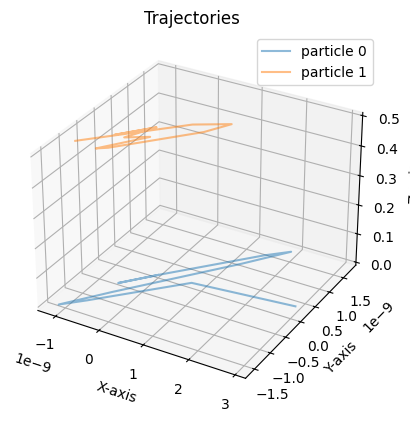

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(r_total[:,0,0], r_total[:,0,1], r_total[:,0,2], alpha=0.5, label= "particle 0")
ax.plot(r_total[:,1,0], r_total[:,1,1], r_total[:,1,2], alpha=0.5, label= "particle 1")

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('Trajectories ')
plt.legend()

Text(0.5, 1.0, 'Temperature over time')

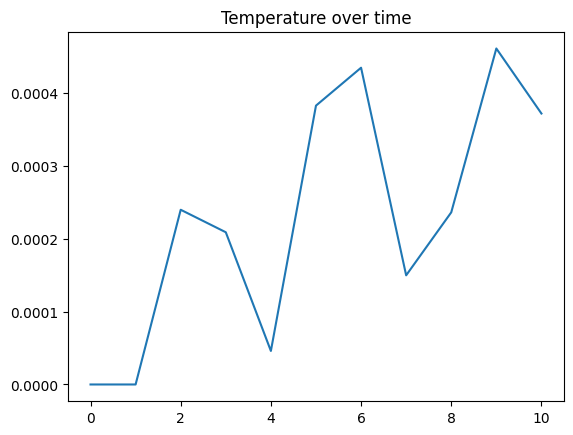

In [36]:
T_total = [Temperature(v_t) for v_t in v_total]
plt.plot(np.arange(t_max+1), T_total)
plt.title("Temperature over time")

0.5
16384.0
0.5
16384.0
0.7071067811865476
127.99999999999987
0.5
16384.0
0.7071067811865476
127.99999999999987
0.7071067811865476
127.99999999999987
0.8660254037844386
7.491540923639695
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814
0.3535533905932738
2097151.999999998
0.6123724356957945
958.9172382258814
0.6123724356957945
958.9172382258814

Text(0.5, 1.0, 'Force that acts on particle 0 in x-direction over time')

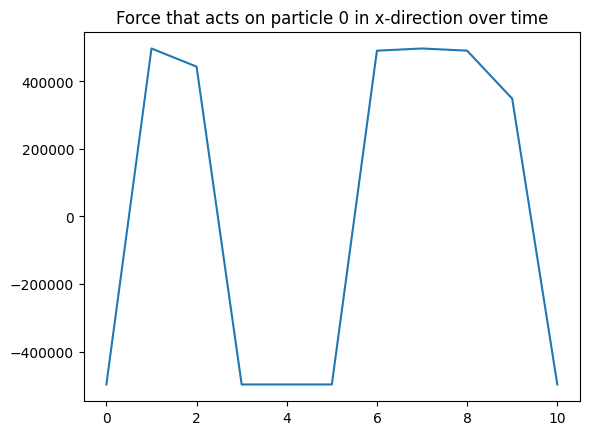

In [37]:
plt.plot(np.arange(t_max+1), [F(r_total[t])[0,0] for t in range(t_max+1)])
plt.title("Force that acts on particle 0 in x-direction over time")